#  The Finite Difference Method

## Library Imports Go Here

In [1]:
import math
import cmath
import numpy as np
import time
import matplotlib.pyplot as plt
import random
import scipy.sparse as hungry
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse.linalg import eigsh

## The SHO

<font color = blue>
Consider the plain simple harmonic oscillator, which (once made appropriately dimensionless) satisfies the equation

$$
\ddot{x} + x = 0
$$

Okay.

### The Analytic Solution

<font color = blue>
Find the general soution to this equation, and then determine what the constants of integration will be in terms of boundary conditions

$$
x_0 = x(0), \hspace{.75in} x_T = x(T)
$$

where $T$ is some pre-determined time (show your work.)  Create a function that takes as inputs the boundary values $x_0$ and $x_T$, the time associated with the boundary value $T$, and the time $t$, and outputs the value $x(t)$ (using your analytic solution.)

Anzatz: $x(t) = A Cos(kt) + B Sin(kt)$ with B=0
$$ x(0) = x_o = x_o Cos(kt) + 0; \; \; \; \;  x(T) = x_T = x_o Cos(kT)  $$\
$$ k=1, \; \; \; \ddot{x} = -k^2 x(t) = x$$\
$$ x(t) = x_o Cos(t) $$

### Generating the Matrix

<font color = blue>
Create a function that will build the matrix $\mathbb{M}$ appropriate to rewriting the differential equation in the form

$$
\mathbb{M}\vec{x} = \vec{s} - \vec{b}
$$

Your matrix should take as inputs the final time $T$ and the size of the matrix $N$, and should be the "coo"-type sparse matrix you learned to construct last time.  (Note: you can begin by copy-pasting the code you wrote last time to generate a generic sparse matrix into this notebook.)  Check that it is working by generating a $9 \times 9$ matrix with $T = 1$.

In [2]:
def sparse_matrix(A,B,C,N,x_inf):
    dx = x_inf/(N+1)
    j_array = np.array([0.]*(3*N-2), dtype=float)
    i_array = np.array([0.]*(3*N-2), dtype=float)
    data = np.array([0.]*(3*N-2), dtype=float)
    #for indicies of j,i, make lists containing the values of indicies and data that aren't zero in the array.
    for n in range(N):
        if n == 0:
            x_j = n*dx
            j_array[3*n:3*n+2] = n,n
            i_array[3*n:3*n+2] = n,n+1
            data[3*n:3*n+2] = C(x_j) - 2*A(x_j)/dx**2, A(x_j)/dx**2 + B(x_j)/(2*dx)
        elif n==N-1:
            x_j = n*dx
            j_array[-3:-1] = n,n
            i_array[-3:-1] = n-1,n
            data[-3:-1] = A(x_j)/dx**2 - B(x_j)/(2*dx), C(x_j) - 2*A(x_j)/dx**2
            
            #a bad fix to the number on the second to last row, Nth column not being filled
            j_array[-1] = n-1
            i_array[-1] = n
            data[-1] = A(x_j-dx)/dx**2 + B(x_j-dx)/(2*dx)
        else: 
            x_j = dx*n
            j_array[3*n-1:3*n+2] = n,n,n
            i_array[3*n-1:3*n+2] = n-1,n,n+1
            data[3*n-1:3*n+2] = A(x_j)/dx**2 - B(x_j)/(2*dx) , C(x_j) - 2*A(x_j)/dx**2, A(x_j)/dx**2 + B(x_j)/(2*dx)
    
    
    data[-3:-1] = A(x_j)/dx**2 - B(x_j)/(2*dx), C(x_j) - 2*A(x_j)/dx**2
    
    filled_matrix=hungry.coo_matrix((data,(j_array,i_array)),shape=(N, N))
    
    return filled_matrix

In [3]:
#inputs a set function into the sparce matrix, really just increasing ease of use
def theDumb(N,T):
    def A(x):
        return 1
    def B(x):
        return 0
    def C(x):
        return 1
    return sparse_matrix(A,B,C,N,T)

print(theDumb(9,1).toarray())

[[-199.  100.    0.    0.    0.    0.    0.    0.    0.]
 [ 100. -199.  100.    0.    0.    0.    0.    0.    0.]
 [   0.  100. -199.  100.    0.    0.    0.    0.    0.]
 [   0.    0.  100. -199.  100.    0.    0.    0.    0.]
 [   0.    0.    0.  100. -199.  100.    0.    0.    0.]
 [   0.    0.    0.    0.  100. -199.  100.    0.    0.]
 [   0.    0.    0.    0.    0.  100. -199.  100.    0.]
 [   0.    0.    0.    0.    0.    0.  100. -199.  100.]
 [   0.    0.    0.    0.    0.    0.    0.  100. -199.]]


### Generating the Boundary Vector

<font color = blue>
We would now like to create a function that generates our "boundary vector".  It should take as inputs the size of the vector $N$, the final time $T$, and the two boundary values $x_0$ and $x_T$.  Make sure that your function is working properly by generating a vector of length 4, with $T = 1$, $x_0 = 1$, and $x_T = 2$.

Also consider: what is the source vector $\vec{s}$ in this problem?

.

We could work hard at it and generate this in sparse form, but it turns out not to be super-important.  Essentially the "sparse" structure is designed to make sure we don't use up memory space in the computer storing a bunch of zeroes: instead we only store those elements of the matrix or vector which are non-zero.  But in this problem the matrix you have just created will have of order $N$ non-zero elements.  If we now store all $N$ elements of the vector $\vec{b}$, even those which aren't zero, we haven't changed the scaling of the number of values we are storing (it is still just of order $N$).

In [4]:
#this contains the boundry condition information
def bVector(N,T,x_o,x_t):
    dt = T / (N+1)
    vector=hungry.coo_matrix(([x_t/dt**2,x_o/dt**2],([N-1,0],[0,0])),shape=(N, 1))
    return vector
    
print(bVector(4,1,1.0,2.0).toarray())

[[25.]
 [ 0.]
 [ 0.]
 [50.]]


### The Solution Maker

<font color = blue>
We now want to use these pieces to create and analyze solutions to our differential equation

Begin by writing a function that will take as inputs the time $T$, size of the matrix and vector $N$, and boundary conditions $x_0$ and $x_T$, and output both a list of times $[t_n]$ and a list of positions $[x_n]$.  To do this you will want to use the function "inv" from the "scipy.sparse.linalg" library.  Furthermore, it may be easiest to take the output of this inverted matrix and convert it to a numpy array, and use the numpy function "dot" to take the matrix product of the inverted matrix with the boundary vector.

In [12]:
#taking solus in a solution vector of this specific equation
def solus(N,new_t,x_o,x_t):
    inv_M = hungry.linalg.inv(theDumb(N,new_t))
    neg_b = - bVector(N,new_t,x_o,x_t)
    time = np.arange(0,N*new_t/(N+1.0),new_t/(N+1.0))
    return time,(inv_M*neg_b).toarray()

<font color = blue>
Then, test your function by using three random choices of $x_0$ and $x_T$.  Use a grid of $N = 1000$ points, and $T = 10$.  Plot the results together with the analytic results you established earlier.

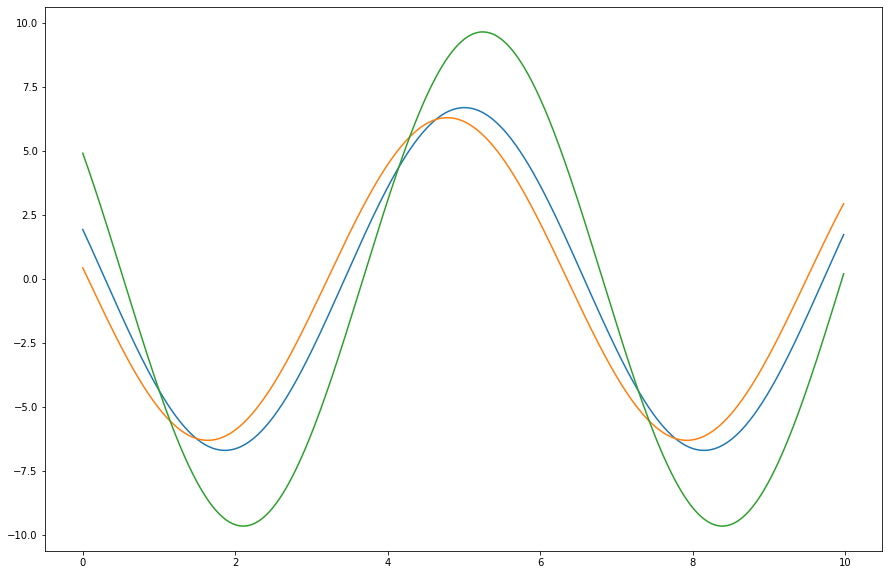

In [13]:
N=1000
T=10

fig = plt.figure(figsize=(15,10))
data1 = solus(N,T,2.0,1.8)
data2 = solus(N,T,0.5,3.0)
data3 = solus(N,T,5.0,0.3)
plt.plot(*data1)
plt.plot(*data2)
plt.plot(*data3)
plt.show()

Each start at their initial conditions and end at the other boundry condition, with a trig function in between. Seems correct, nothing has exploded.

<font color = blue>
Now attempt to use the function to find the solution with $T = 2\pi$ and $x_0 = 0$ and $x_T = 2$.  What happens?  First explain *physically* why there are no valid solutions for these conditions.  Then explain in terms of the analytic mathematical solution you found earlier.  Finally, what do you think goes wrong in terms of the linear algebra problem you are now posing?

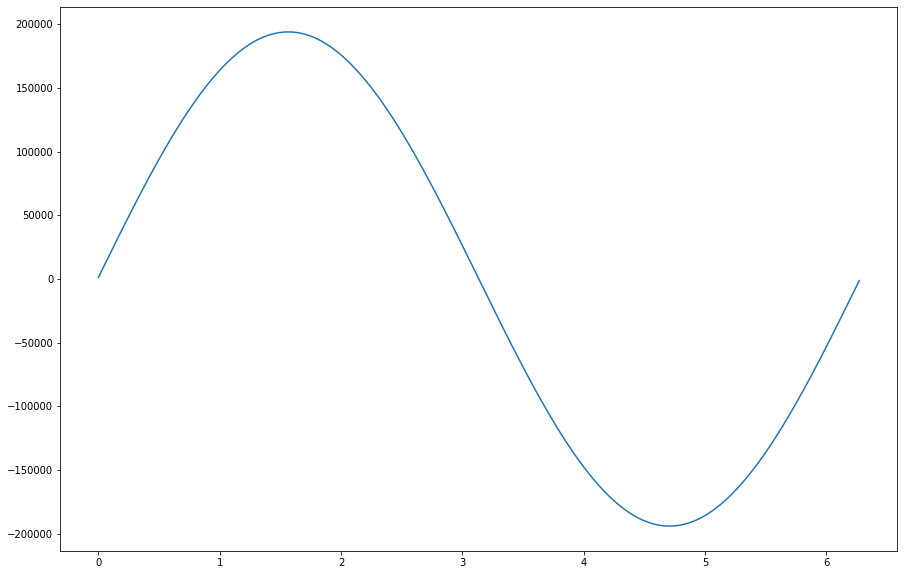

In [7]:
fig = plt.figure(figsize=(15,10))
data3 = solus(N,2*math.pi,0.0,2.0)
plt.plot(*data3)
plt.show()

Thats some error! Immediately explodes- Physicaly, the boundry conditions dont quite make sense, the sine function at a x=$2\pi$ equals 0 snd so will this approximation with some error, so this huge increase in amplitude is so the error is enought at that x value to reach the y value at the final condition. Is the maxtric I create non-hermetian in this circumstance? That was a major assumption for this to operate correctly.

## The Damped, Driven SHO with Sinusoidal Driving

<font color = blue>
Now consider the damped, driven SHO system, which (once properly non-dimensionalized) satisfies the equation

$$
\ddot{x} + x + 2\beta\dot{x} = \cos\Omega t
$$

in which case the known analytic solution is

$$
x(t) = e^{-\beta t}\left[A\cos\Big(t\sqrt{1 - \beta^2}\Big) + B\sin\Big(t\sqrt{1 - \beta^2}\Big)\right] + \frac{(1 - \Omega^2)\cos\Omega t + 2\beta\Omega\sin \Omega t}{(\Omega^2 - 1)^2 + 4\beta^2\Omega^2}
$$

okay

### Matrix Maker

<font color = blue>
Create a new function to generate the appropriate matrix $\mathbb{M}$ that puts this diferential equation into the form

$$
\mathbb{M}\vec{x} = \vec{s} - \vec{b}
$$

Your matrix should take as inputs the final time $T$, and the size of the matrix $N$, along with the damping parameter $\beta$, and should output a coo-matrix.

In [8]:
#hardcodes the DDSHOw/SD function into the sparce matrix
def theSmart(N,T,beta):
    def A(x):
        return 1
    def B(x):
        return 2*beta
    def C(x):
        return 1
    return sparse_matrix(A,B,C,N,T)

### Source Maker

<font color = blue>
Now create a function that generates the source vector $\vec{s}$.  It should take as inputs the matrix size $N$, total time $T$, and driving frequency $\Omega$, and should output an ordinary numpy array.  (Why is it obvious it's not worth using sparse structures here?)  Plot the results to make sure they are doing what they are supposed to, with $N = 1000$, $T = 10$, and $\Omega = 1$.

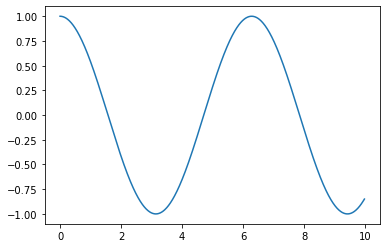

In [9]:
#Input driving force
def source(N,T,omega):
    time=np.arange(0,N*T/(N+1),T/(N+1))
    data = np.array([math.cos(omega*t) for t in time])
    #must be in the same form factor as the b vector, an N by 1 array instead of a 1 by N array.
    form_factor = np.array([[0.0]]*(N))
    for i in range(len(time)):
        form_factor[i][0] = math.cos(omega*time[i])
    return form_factor

𝑁=1000
𝑇=10
omega=1

plt.plot(np.arange(0,N*T/(N+1),T/(N+1)),source(N,T,omega))

### Solution Maker

<font color = blue>
Now put the pieces together to create a function that generates a solution to the DDSHO problem, given boundary conditions.  It should take as inputs the total time $T$, the size of the grid $N$, the boundary values $x_0$ and $x_T$, the damping parameter $\beta$, and the driving frequency $\Omega$.  It should output a list of times $[t_n]$ and a list of positions $[x_n]$.  Note that the function you wrote earlier to construct the boundary vector for the SHO problem should be usable here without modification.

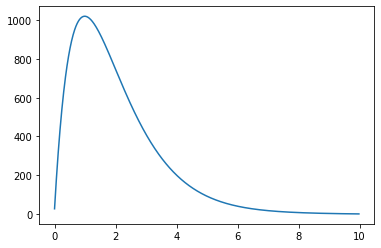

In [15]:
#again, note this is only a solutin for this system because it is hardcoded, only changing initial conditions, range resulution, and frequency
def solution(N,T,omega,beta,x_o,x_t):
    inv_M = hungry.linalg.inv(theSmart(N,T,beta))
    neg_b = - bVector(N,T,x_o,x_t).toarray()
    s_vect = source(N,T,omega) 
    
    SminB=s_vect + neg_b
    time = np.arange(0,N*T/(N+1.0),T/(N+1.0))
    return time,(inv_M*SminB)


#testing
plt.plot(*solution(N,T,omega,1.0,0.0,1.0))
plt.show()

### * Steady State Behavior and Initial Conditions

<font color = blue>
The DDSHO is an unusual problem to attempt to solve as a boundary value problem, because it has the interesting feature that, no matter what initial conditions are given to the oscillator, after enough time the solution should closely match the steady-state behavior, which is

$$
x(t) \approx \frac{(1 - \Omega^2)\cos \Omega t + 2\beta\Omega\sin \Omega t}{(\Omega^2 - 1)^2 + 4\beta^2\Omega^2}
$$

Suppose we consider $\beta = 0.5$ and $T = 10$, so that the exponential suppression factor on the transient part of the solution is 

$$
e^{-5} \approx .007
$$

by the end of the time $T$.  Say further that $\Omega = 2$.  Find, using the equations above, what the steady state part of the solution is at time $T$.  Let's call this $x_{ST}$.

Then, use your function to generate a family of solutions to the DDSHO system for these values of $\beta$, $\Omega$, and $T$,  For each member of the family, use $N = 1000$ and $x_0 = 1$.  For the other boundary value, use $x_T = x_{ST} + \delta$, where $\delta$ is a number between 0 and 1 in steps of 0.1.  Plot the results in a single graph.

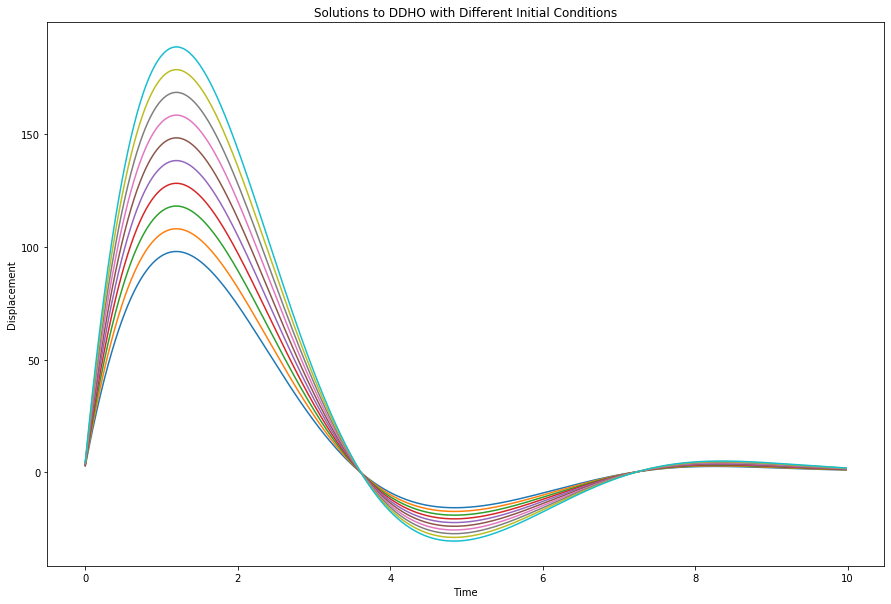

In [11]:
fig = plt.figure(figsize=(15,10))
for i in np.arange(0,1.0,0.1):
    data = solution(1000,10,2.0,0.5,1.0,1.0+i)
    plt.plot(*data)
plt.title('Solutions to DDHO with Different Initial Conditions')
plt.ylabel('Displacement')
plt.xlabel('Time')
plt.show()

This beautiful plot shows the effect on the problem solution if the final displacement value is altered in a DDSHO. The amplitude has to increase significantly to end on a slightly different value. 

## The Poisson Problem

<font color = blue>
We now want to use the finite difference method to solve a linear PDE problem in 2-dimensions, of the form

$$
\nabla^2\phi = -\rho
$$

where $\rho$ is a (dimensionless) position-dependent charge density $\rho(x, y)$.  We will assume we are looking for the potential in a square with corners at $(0,0)$, $(0,1)$, $(1,0)$, and $(1,1)$, and we will assume the potential is specified (but isn't necessarily constant) on all four sides of this square.  We are interested in converting this problem into the form

$$
\mathbb{M}\vec{\phi} = \vec{s} - \vec{b}
$$

### Creating the Matrix

<font color = blue>
Let's assume we use a spatial grid for our box with size $N$, so that $\Delta = \frac{1}{N+1}$.  Create a function taht will take as input the value of $N$, and output (as a coo-matrix) a matrix $\mathbb{M}$.  Note that this matrix must be $N^2 \times N^2$.  Check that your function is working properly by creating a matrix for $N = 3$, and confirm that both the values appearing in it and the structure of the matrix are correct.

### Creating the Source Vector

<font color = blue>
Now create a function taht will take as inputs a function of the form $\rho(x, y)$ and the size of the grid $N$, and outputs the appropriate source vector $\vec{s}$ as a standard numpy array with $N^2$ components.

### Repackaging Function

<font color = blue>
Although we want to have our sources, boundaries, and resulting electric potentials stored as vectors with $N^2$ components, in order to display these objects we actually want them stored as $N \times N$ matrices.  Because of this, we now want to create a function that will take one of these $N^2$ vectors and repackage it as a matrix.  

Then, we want to use this function to test the output of our source vector creating code:  use the functions $\rho(x, y) = x$ and $\rho(x, y) = y$, with $N = 3$ to create two source vectors.  Then, feed these source vectors into your repackaging function, to create two matrices.  Check each to make sure they have the correct structure.

Finally, use matplotlib.pyplot.imshow to display them as density plots.  

### Generating the Boundary Vector

<font color = blue>
Next we need a function that will generate the boundary vector $\vec{b}$.  Let's assume we want to define the potential on the boundary box in terms of four functions:

$T(x)$ giving the function on the top, with $y = 1$ and $0 < x < 1$,

$B(x)$ giving the function on the bottom, with $y = 0$ and $0 < x < 1$,

$L(y)$ giving the function on the left, with $x = 0$ and $0 < y < 1$, 

$R(y)$ giving the function on the right, with $x = 1$ and $0 < y < 1$.

Create a function that will output the boundary vector, with the four functions $T$, $B$, $L$, and $R$, and the size of the grid $N$, as inputs.  Again, use the "repackaging" function and the "imshow" function to make sure this is working properly.



### * Grounded Boundary, Isolated Charge

<font color = blue>
Now that we have all of the necessary pieces, we can use them to actually solve Poisson's equation for various choices of boundaries and sources.  Let's start with a system where the boundary box is grounded, with an isolated charge in the center.  We can use the function

$$
\rho(x, y) = \left\{\begin{array}{rcl} 1 & \mbox{for} & (x - .5)^2 + (y - .5)^2 \le 0.01 \\ \\ 0 & \mbox{for} & (x - .5)^2 + (y - .5)^2 > 0.01 \end{array}\right.
$$

to model our isolated charge.  Set N = 50.  Generate the potential $\phi(x, y)$ as an $N \times N$ matrix, and use "contourf" in the "matplotlib.pyplot" library to display it.  (To use this, you will also need arrays of x- and y-coodinates.)

### * Grounded Boundary, Parallel Plates

<font color = blue>
Repeat the previous exercise, but this time we will model a source that is a pair of oppositely charged plates.  (We will again ues a grounded boundary.)  We can create the plates using

$$
\rho(x, y) = \left\{\begin{array}{rcl} +1 & \mbox{for} & 0.25 < x < .75, \ \ \ .7 < y < .71 \\ \\
-1 & \mbox{for} & 0.25 < x < .75, \ \ \ .29 < y < .3 \end{array}\right.
$$

(with the density vanishing outsides these ranges.)

### * Isolated Walls, No Charge

<font color = blue>
Now let's work with no source term, but hold the four walls of the box each at a different constant voltage, with the top at +1, the bottom at -1, the left side at +2, and the right side at -2.

### * Isolated Charge, Isolated Walls

<font color = blue>
Finally, let's look at one more case.  Use the same isolated charge you considered in the first example.  But this time, hold the top of the box at $\phi = +0.01$, the bottom at $\phi = -0.01$, and ground the two side walls.

## Final Project Proposal

<font color = blue>
Due along with this week's notebook is your final project proposal (do this separate from the Mathematica notebook, L AT EX preferred.)  This proposal should be 2-3 pages and include:

1) A brief qualitative discussion of the problem you are interested in along with why it is interesting.

2) A more detailed mathematical discussion of the problem, establishing and explaining/deriving the essential equations, ready for computer analysis.  (This is where most of the work should be put in.)

3) An explanation of why the problem is appropriate for numerical analysis, and of what specific numerical technique(s) you plan to utilize.

4) A specific plan for what you intend to accomplish in the following WEEK.  (For example, "I plan to write the basic RK4 code for the system and confirm that it is working by using such-and-such test case")

5) Citations for external references appropriate to the problem.